In [4]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import plotly.io as pio
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.fft import fft
from scipy.stats import kruskal, zscore
from sklearn.ensemble import RandomForestClassifier

# Set professional plotting style
plt.style.use('ggplot')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.family'] = 'Arial'
custom_palette = ["#3498db", "#e74c3c", "#2ecc71", "#f39c12", "#9b59b6"]
sns.set_palette(custom_palette)

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [5]:
# Load data with progress bar
def load_data():
    data_files = {
        'train': '/kaggle/input/cmi-detect-behavior-with-sensor-data/train.csv',
        'test': '/kaggle/input/cmi-detect-behavior-with-sensor-data/test.csv',
        'train_demo': '/kaggle/input/cmi-detect-behavior-with-sensor-data/train_demographics.csv',
        'test_demo': '/kaggle/input/cmi-detect-behavior-with-sensor-data/test_demographics.csv'
    }
    data = {}
    with tqdm(total=len(data_files), desc="Loading Data") as pbar:
        for name, file in data_files.items():
            try:
                data[name] = pd.read_csv(file)
                pbar.update(1)
            except FileNotFoundError:
                print(f"Error: {file} not found. Please check the file path.")
                return None
    return data

data = load_data()
if data is None:
    raise FileNotFoundError("Data loading failed.")
train, test, demo_train, demo_test = data['train'], data['test'], data['train_demo'], data['test_demo']

# Display basic dataset info
print("Train Shape:", train.shape)
print("Test Shape:", test.shape)
print("Train Demographics Shape:", demo_train.shape)
print("Test Demographics Shape:", demo_test.shape)

Loading Data:   0%|          | 0/4 [00:00<?, ?it/s]

Train Shape: (574945, 341)
Test Shape: (107, 336)
Train Demographics Shape: (81, 8)
Test Demographics Shape: (2, 8)


In [11]:
train.head(3)

,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,...,tof_5_v54,tof_5_v55,tof_5_v56,tof_5_v57,tof_5_v58,tof_5_v59,tof_5_v60,tof_5_v61,tof_5_v62,tof_5_v63
0,SEQ_000007_000000,Target,SEQ_000007,0,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.683594,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,SEQ_000007_000001,Target,SEQ_000007,1,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.949219,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,SEQ_000007_000002,Target,SEQ_000007,2,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.722656,...,-1.0,-1.0,112.0,119.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [14]:
demo_train.head(3)

,subject,adult_child,age,sex,handedness,height_cm,shoulder_to_wrist_cm,elbow_to_wrist_cm
0,SUBJ_000206,1,41,1,1,172.0,50,25.0
1,SUBJ_001430,0,11,0,1,167.0,51,27.0
2,SUBJ_002923,1,28,1,0,164.0,54,26.0


In [15]:
train.isna().sum()

row_id                  0
sequence_type           0
sequence_id             0
sequence_counter        0
subject                 0
                    ...  
tof_5_v59           30142
tof_5_v60           30142
tof_5_v61           30142
tof_5_v62           30142
tof_5_v63           30142
Length: 341, dtype: int64

Note 1 : Missing Values for Sensors (Mostly due to hardware issues).

In [17]:
demo_train.isna().sum()

subject                 0
adult_child             0
age                     0
sex                     0
handedness              0
height_cm               0
shoulder_to_wrist_cm    0
elbow_to_wrist_cm       0
dtype: int64

In [21]:
train.describe()

,sequence_counter,acc_x,acc_y,acc_z,rot_w,rot_x,rot_y,rot_z,thm_1,thm_2,...,tof_5_v54,tof_5_v55,tof_5_v56,tof_5_v57,tof_5_v58,tof_5_v59,tof_5_v60,tof_5_v61,tof_5_v62,tof_5_v63
count,574945.000000,574945.000000,574945.000000,574945.000000,571253.000000,571253.000000,571253.000000,571253.000000,567958.000000,567307.000000,...,544803.000000,544803.000000,544803.000000,544803.000000,544803.000000,544803.000000,544803.000000,544803.000000,544803.000000,544803.000000
mean,43.645234,1.639980,1.790704,-0.459811,0.360375,-0.119916,-0.059953,-0.188298,27.076450,27.133483,...,29.395651,26.030826,45.342583,43.074842,40.045908,37.631707,34.977928,31.934330,29.024752,27.320358
std,45.717673,5.781259,5.003945,6.096490,0.225739,0.465520,0.543028,0.504137,3.231948,2.941438,...,58.093844,54.215523,68.466064,68.017631,66.941587,65.288710,63.201604,60.440645,57.218513,55.407192
min,0.000000,-34.585938,-24.402344,-42.855469,0.000000,-0.999146,-0.999695,-0.998169,-0.370413,21.958820,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,17.000000,-2.964844,-2.121094,-5.417969,0.180237,-0.456299,-0.511536,-0.627686,24.753527,24.543737,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,35.000000,2.972656,0.695312,-1.562500,0.340332,-0.186890,-0.112610,-0.263916,26.982324,26.354338,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
75%,54.000000,6.343750,6.816406,5.164062,0.503479,0.204590,0.440063,0.251099,29.425036,29.620147,...,34.000000,24.000000,81.000000,76.000000,67.000000,59.000000,51.000000,42.000000,35.000000,31.000000
max,699.000000,46.328125,27.183594,30.078125,0.999390,0.999817,0.999451,0.999878,38.457664,37.578339,...,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000


In [22]:
demo_train.describe()

,adult_child,age,sex,handedness,height_cm,shoulder_to_wrist_cm,elbow_to_wrist_cm
count,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000
mean,0.518519,21.814815,0.617284,0.876543,167.993827,51.580247,25.469136
std,0.502770,10.289693,0.489078,0.331010,10.605863,4.888415,3.025254
min,0.000000,10.000000,0.000000,0.000000,135.000000,41.000000,18.000000
25%,0.000000,13.000000,0.000000,1.000000,163.000000,49.000000,24.000000
50%,1.000000,22.000000,1.000000,1.000000,170.000000,52.000000,25.000000
75%,1.000000,27.000000,1.000000,1.000000,174.000000,55.000000,27.000000
max,1.000000,53.000000,1.000000,1.000000,190.500000,71.000000,44.000000


Note 2 : Some people are left handed.

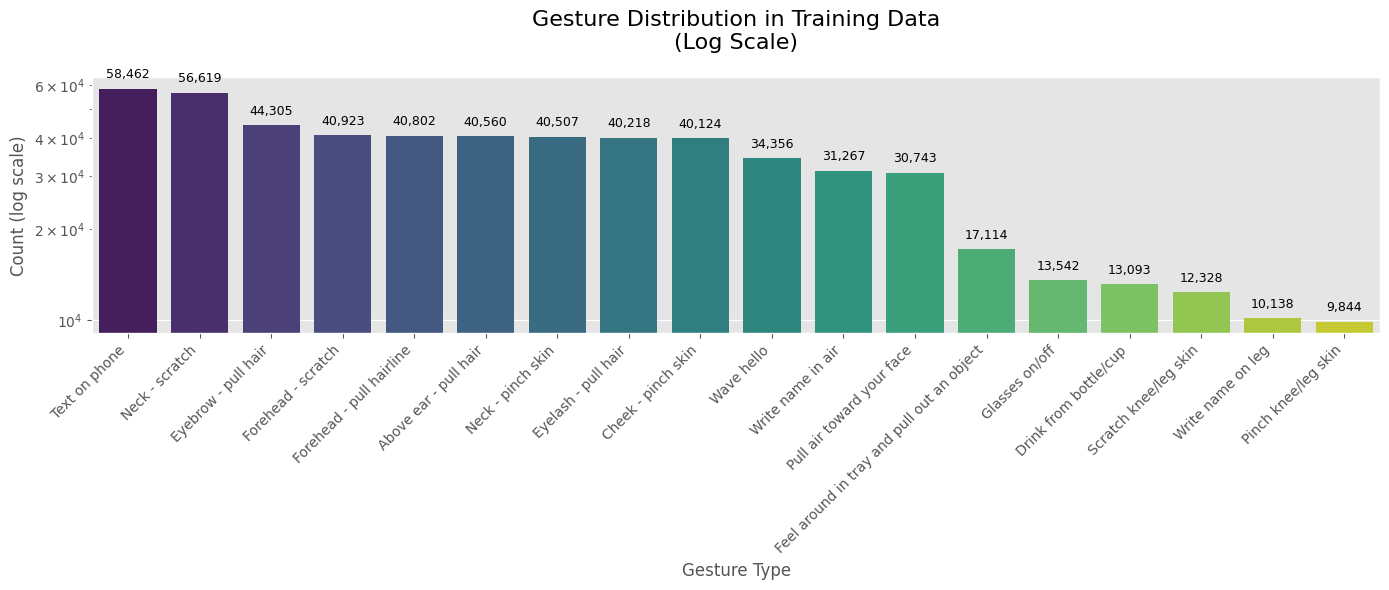

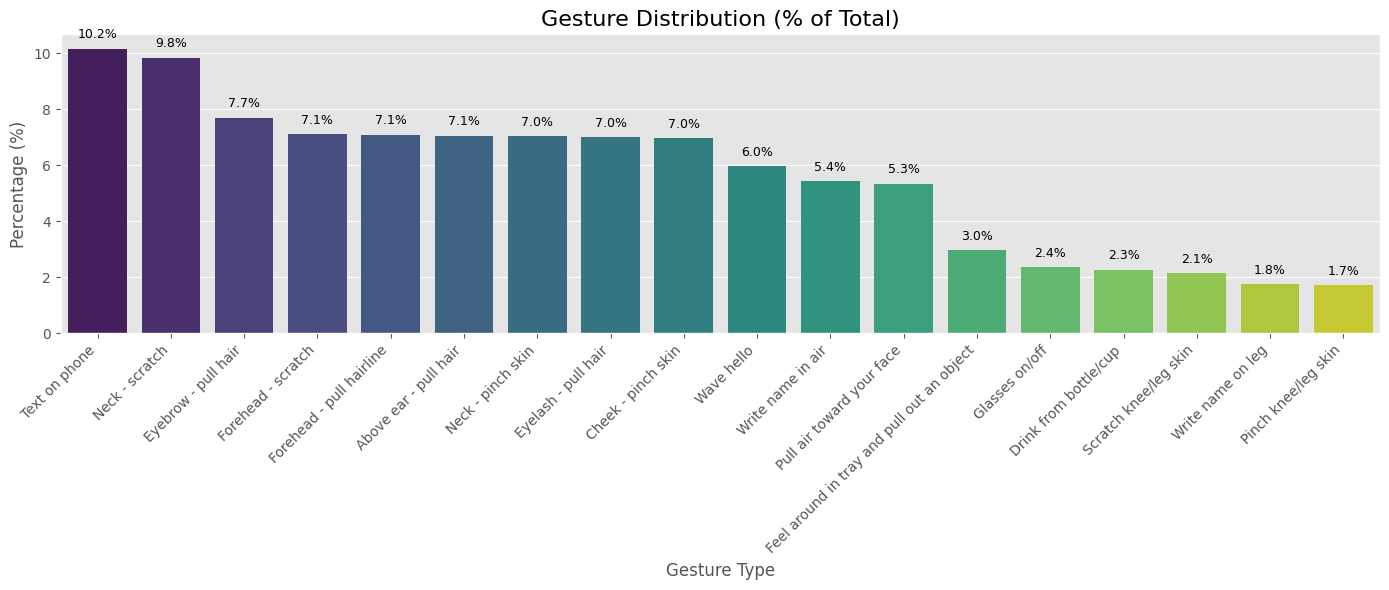

In [6]:
def plot_gesture_distribution(df):

    gesture_counts = df['gesture'].value_counts().sort_values(ascending=False)
    gesture_percentages = gesture_counts / gesture_counts.sum() * 100

    # Bar plot with counts
    plt.figure(figsize=(14, 6))
    ax = sns.barplot(x=gesture_counts.index, y=gesture_counts.values, 
                     order=gesture_counts.index, palette='viridis')
    plt.title('Gesture Distribution in Training Data\n(Log Scale)', fontsize=16, pad=20)
    plt.xlabel('Gesture Type', fontsize=12)
    plt.ylabel('Count (log scale)', fontsize=12)
    plt.yscale('log')
    plt.xticks(rotation=45, ha='right')
    
    # Add count annotations
    for p in ax.patches:
        ax.annotate(f"{int(p.get_height()):,}", 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), 
                    textcoords='offset points', fontsize=9)
    
    plt.tight_layout()
    plt.show()

    # Percentage plot
    plt.figure(figsize=(14, 6))
    ax = sns.barplot(x=gesture_percentages.index, y=gesture_percentages.values, 
                     order=gesture_counts.index, palette='viridis')
    plt.title('Gesture Distribution (% of Total)', fontsize=16)
    plt.xlabel('Gesture Type', fontsize=12)
    plt.ylabel('Percentage (%)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    
    # Add percentage annotations
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.1f}%", 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), 
                    textcoords='offset points', fontsize=9)
    
    plt.tight_layout()
    plt.show()

plot_gesture_distribution(train)


NOTE 3 : Classes are Imbalanced

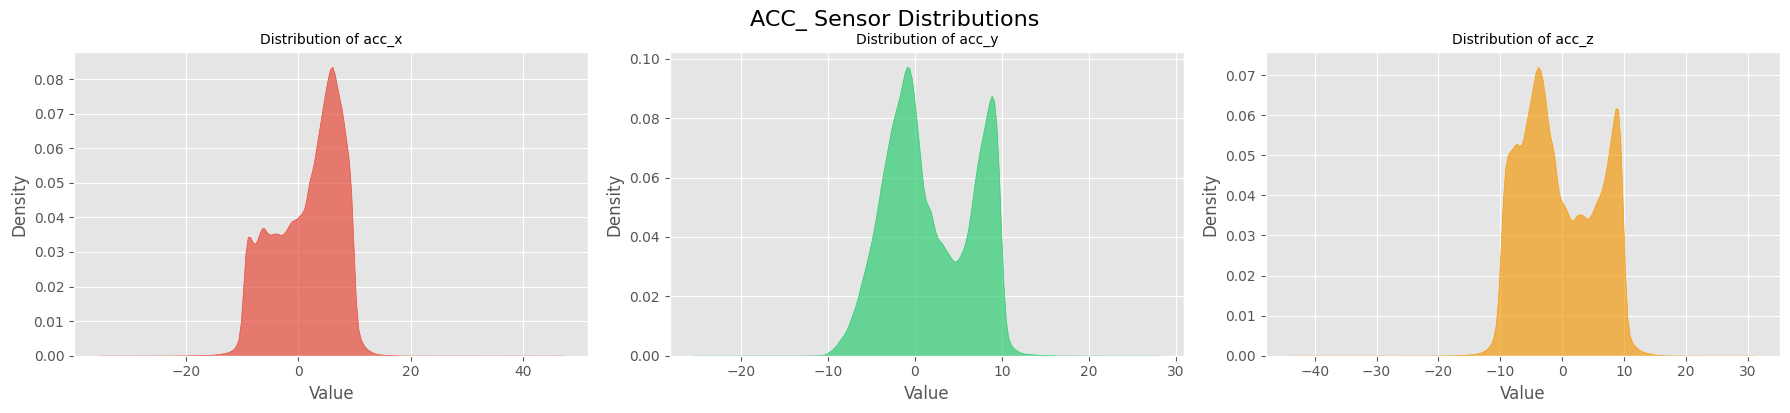


Summary Statistics for acc_ Sensors:
               acc_x          acc_y          acc_z
count  574945.000000  574945.000000  574945.000000
mean        1.639980       1.790704      -0.459811
std         5.781259       5.003945       6.096490
min       -34.585938     -24.402344     -42.855469
25%        -2.964844      -2.121094      -5.417969
50%         2.972656       0.695312      -1.562500
75%         6.343750       6.816406       5.164062
max        46.328125      27.183594      30.078125


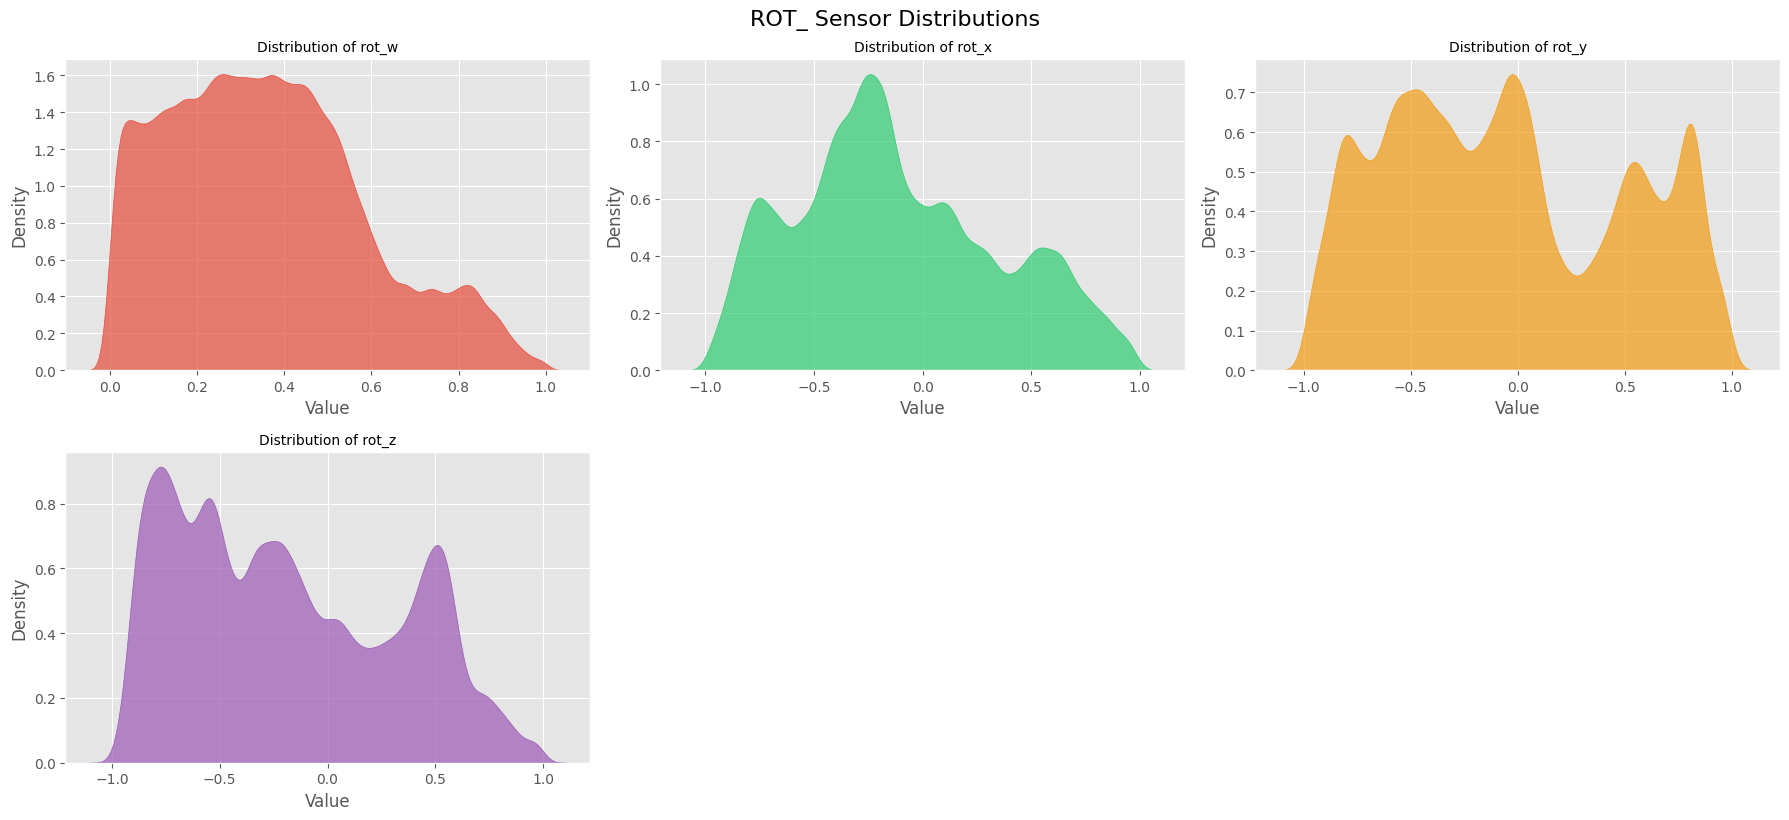


Summary Statistics for rot_ Sensors:
               rot_w          rot_x          rot_y          rot_z
count  571253.000000  571253.000000  571253.000000  571253.000000
mean        0.360375      -0.119916      -0.059953      -0.188298
std         0.225739       0.465520       0.543028       0.504137
min         0.000000      -0.999146      -0.999695      -0.998169
25%         0.180237      -0.456299      -0.511536      -0.627686
50%         0.340332      -0.186890      -0.112610      -0.263916
75%         0.503479       0.204590       0.440063       0.251099
max         0.999390       0.999817       0.999451       0.999878


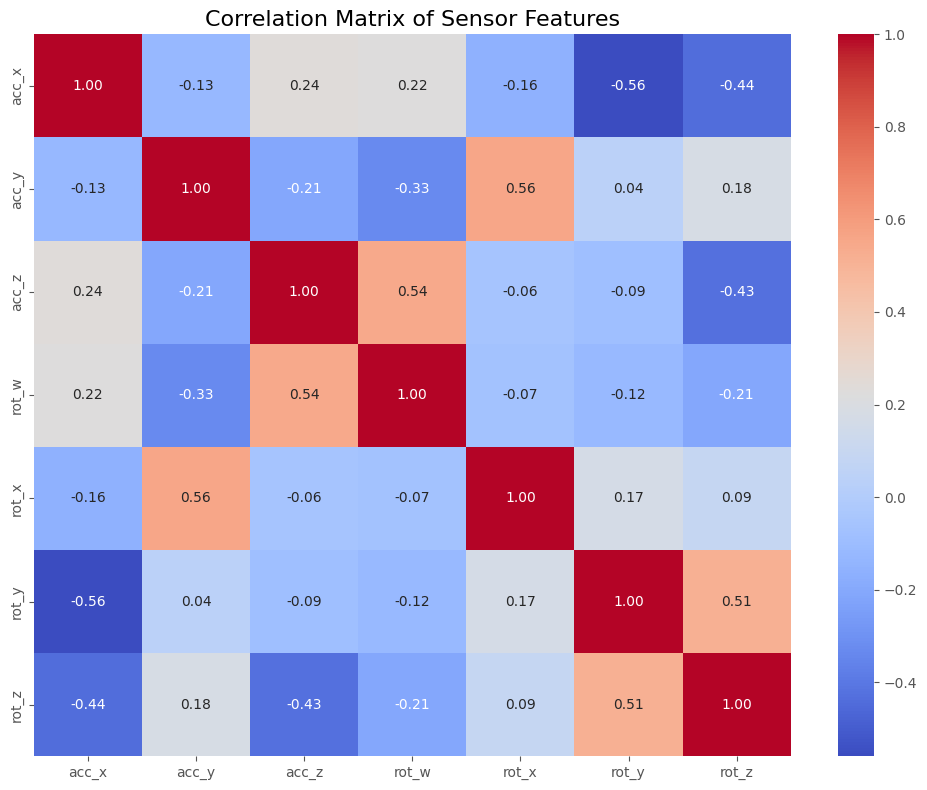

In [7]:
def plot_sensor_distributions(df, sensor_type, cols_per_row=3):
    sensor_cols = [col for col in df.columns if sensor_type in col]
    if not sensor_cols:
        print(f"No columns found for {sensor_type}.")
        return
    
    n_cols = len(sensor_cols)
    n_rows = (n_cols + cols_per_row - 1) // cols_per_row
    
    plt.figure(figsize=(18, 4 * n_rows))
    for i, col in enumerate(sensor_cols, 1):
        plt.subplot(n_rows, cols_per_row, i)
        sns.kdeplot(df[col].dropna(), fill=True, alpha=0.7, color=custom_palette[i % len(custom_palette)])
        plt.title(f'Distribution of {col}', fontsize=10)
        plt.xlabel('Value')
        plt.ylabel('Density')
    plt.tight_layout()
    plt.suptitle(f'{sensor_type.upper()} Sensor Distributions', y=1.02, fontsize=16)
    plt.show()

    # Summary statistics
    print(f"\nSummary Statistics for {sensor_type} Sensors:")
    print(df[sensor_cols].describe())

# Plot accelerometer and rotation distributions
plot_sensor_distributions(train, 'acc_')
plot_sensor_distributions(train, 'rot_')

# Correlation heatmap
sensor_cols = [col for col in train.columns if 'acc_' in col or 'rot_' in col]
if sensor_cols:
    plt.figure(figsize=(10, 8))
    sns.heatmap(train[sensor_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix of Sensor Features', fontsize=16)
    plt.tight_layout()
    plt.show()

NOTE 4 : Some features are highly correlated

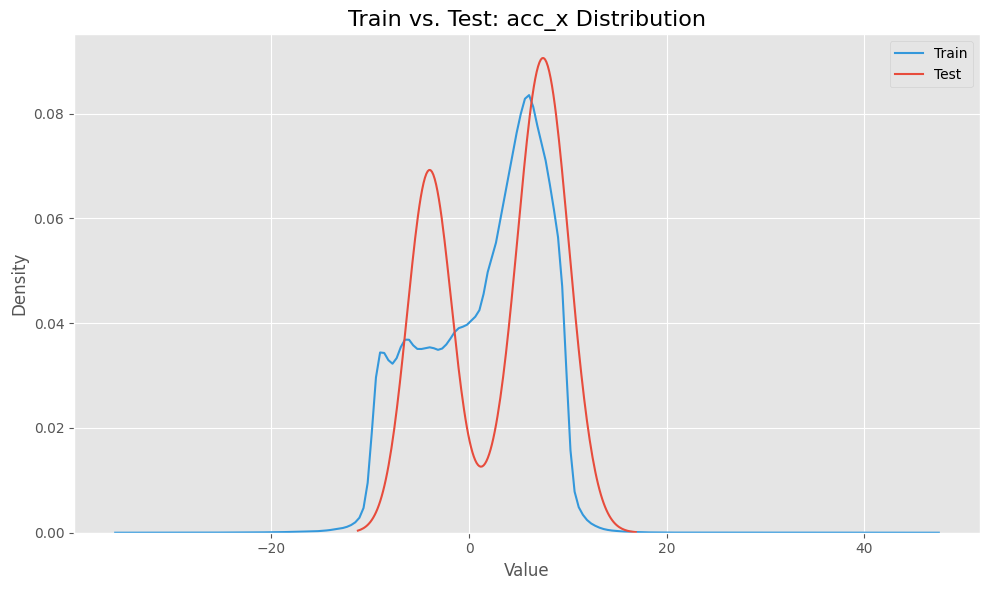

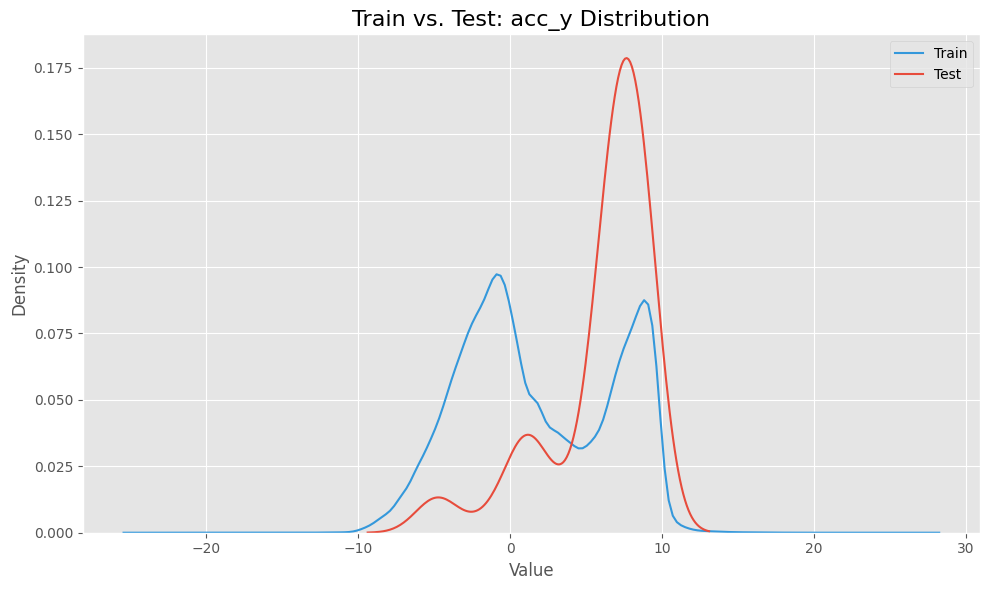

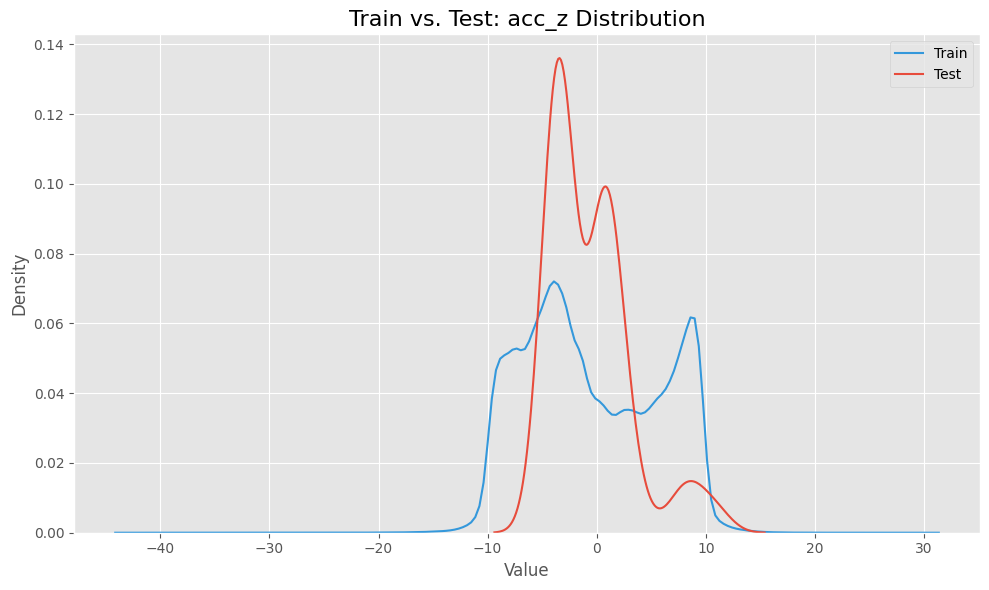

In [8]:
def compare_train_test(train_df, test_df):
    sensor_cols = [col for col in train_df.columns if 'acc_' in col or 'rot_' in col]
    for sensor in sensor_cols[:3]:  # Limit to first 3 for brevity
        plt.figure(figsize=(10, 6))
        sns.kdeplot(train_df[sensor].dropna(), label='Train', color=custom_palette[0])
        sns.kdeplot(test_df[sensor].dropna(), label='Test', color=custom_palette[1])
        plt.title(f'Train vs. Test: {sensor} Distribution', fontsize=16)
        plt.xlabel('Value')
        plt.ylabel('Density')
        plt.legend()
        plt.tight_layout()
        plt.show()

compare_train_test(train, test)

NOTE 5: Train and Test Data Distribution is almost similar.

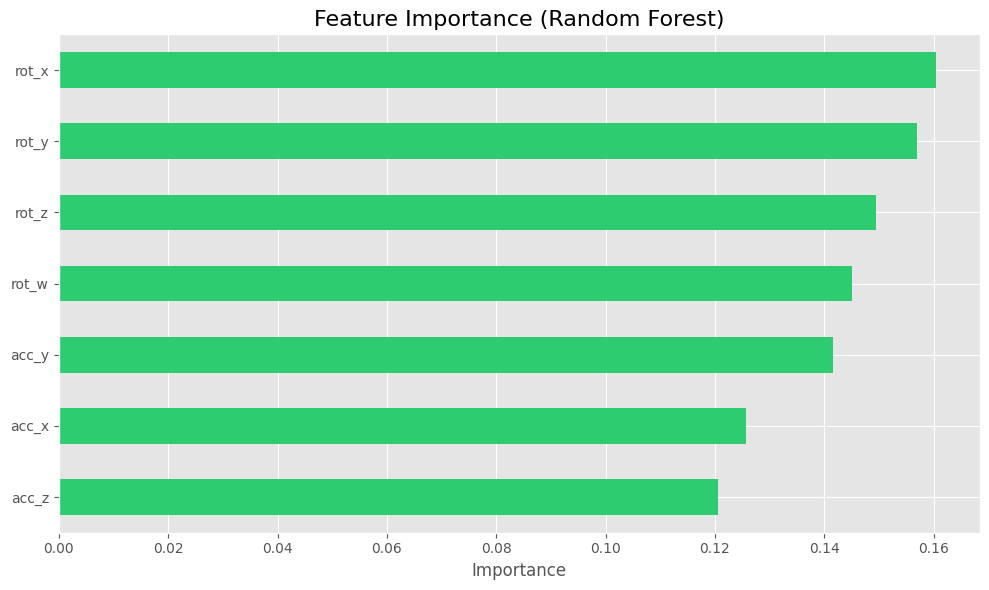

In [9]:
def plot_feature_importance(df):
    sensor_cols = [col for col in df.columns if 'acc_' in col or 'rot_' in col]
    X = df[sensor_cols].fillna(0)  # Simple imputation for demo
    y = df['gesture']
    
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    
    importances = pd.Series(rf.feature_importances_, index=sensor_cols).sort_values()
    plt.figure(figsize=(10, 6))
    importances.plot(kind='barh', color=custom_palette[2])
    plt.title('Feature Importance (Random Forest)', fontsize=16)
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

plot_feature_importance(train)

NOTE 6 : IMU Sensors are more predictive than thm and tofs

# KEY TAKEAWAYS :
1. Missing Values in Sensor Data.
2. Left Handed people are present.
3. Class Imbalance is Present.
4. Few features are strrongly linearly correlated with each other.
5. Train and Test dist are almost similar
6. IMU Sensors are more predictive than other sensors.


#### SOME INSIGHTS I MISSED AND LEARNED FROM READING DISCUSSION :

1. Few subjects wore the watch on left hand.
2. 2 Subjects wore the watch upside down.
   